In [1]:
import os
import sys
from optparse import OptionParser

import numpy as np
import scipy as ci 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

%matplotlib inline 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables 
import pickle
import warnings
from sklearn.externals import joblib
warnings.filterwarnings('once')

In [2]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/'

In [3]:
f = tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r')
f = tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r')

f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:]
# f.root.QTot.cols.value[:][0]
# f.root.Collection.cols.chi2_red[:][0]
# f.root.MCPrimary_coincident.cols.value[:][0]
# f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][0]
# f.root.Collection.cols.len_dEdxVector[:][0]

array([1125.66800089,   57.1445744 ,  301.46403082, ...,  550.24681749,
        134.00936494,  552.70900787])

# IceTop Inefficiency

In [4]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:

    chi2_red_data_burn = f.root.Collection.cols.chi2_red[:]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:]      
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:]
    closest_d_data_burn = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:]
    passed_2 = (f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The following kwargs were not used by contour: 'lw'
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


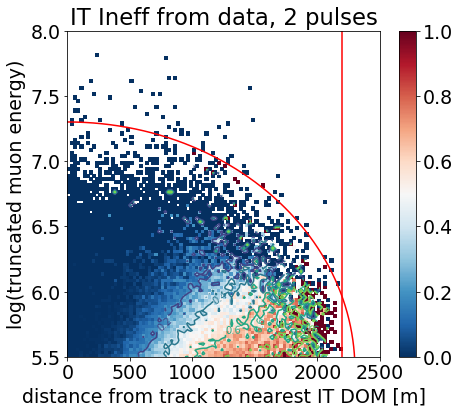

In [5]:
" ----- IT ineff from data -----"
plt.rcParams.update({'font.size': 19})
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

n_ = 100
emax = 8
e_spacing = (emax-5.5)/n_
d_spacing = (2500)/n_

Dist = []
Energy = []
Ineff_2 = []

for energy in np.linspace(5.5,emax,n_): # in each energy range [e1,e2]
    for dist in np.linspace(0,2500,n_): # in each dist range
        # energy cut  

        CUT_energy = (truncated_muon_e_data_burn>10**energy)&(truncated_muon_e_data_burn<10**(energy+e_spacing))
        CUT_dist = (closest_d_data_burn>dist)&(closest_d_data_burn<(dist+d_spacing))
        CUT = CUT_energy & CUT_dist

        closest_d_binned = closest_d_data_burn[CUT]
        passed_2_binned = passed_2[CUT] # events that pass the veto (not rejected)
        total_events_in_Bin = len(closest_d_binned[:]) # total events in this current bin

        Ineff_2 = np.append(Ineff_2, np.sum(passed_2_binned)/total_events_in_Bin ) # fraction of events pass veto in this distance bin

        Dist = np.append(Dist, dist)
        Energy = np.append(Energy,energy)

plt.figure(figsize=(7,6))
h,yy,xx,img=plt.hist2d(Dist,Energy,bins=[n_,n_],weights=Ineff_2,cmap=my_cmap,vmin=0.0) # ,range=[[0,2500],[5.5,emax]],range=[[0,2500],[5.5,emax]],bins=[n_,n_],
plt.colorbar()
CS=plt.contour(h.transpose(),extent=[0,2500,5.5,emax],lw=1,levels=[0.2,0.4,0.6,0.8])
plt.clabel(CS,inline=1,fmt='%1.1f',fontsize=10)
plt.clim(0,1)

# -- ineff low stat cut --
t = np.arange(0,2500,1)
plt.plot(t, 5.4+1.9*np.sqrt(1 - (t)**2/2300**2),color='r')
plt.axvline(2200,color='r')
plt.xlabel('distance from track to nearest IT DOM [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,2500)
plt.ylim(5.5,emax)
plt.title('IT Ineff from data, 2 pulses')
plt.show()

In [6]:
# ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model(dist,E): # E: log10 of energy!!! 

    a = params[0] + params[2] * (E + params[1])**2
    b = params[3] + params[5] * (E + params[4])**2
    val = 10 * a / dist**(1/3.) * np.exp( -10**6 * b / dist**2)
    
    val[val < 0.001] = 0.001 # This is arbitrary! 

    # low stat cut 
    val[E > 5.4+1.9*np.sqrt(1 - (dist)**2/2300**2)]=0.5
    val[dist>2200]=0.5
    return val

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


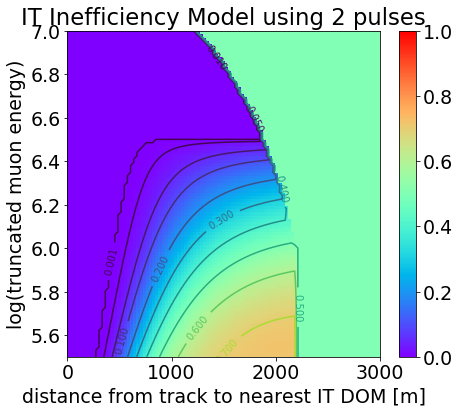

In [7]:
xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model(xg,yg)

plt.figure(figsize=(7,6))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance from track to nearest IT DOM [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('IT Inefficiency Model using 2 pulses')
plt.show()

# Random Forest Training

In [8]:
IT_ineff_cut = 0.01
E_min = 1
E_max = 9.
Z_min = 0.
Z_max = 1

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 74909 # with _rf, the size of broken file is 266K instead of 0! 
    
    ineff_corsika = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_corsika < IT_ineff_cut
#     CUT_phase = (np.cos(f.root.SplineMPE.cols.zenith[:])-0.95)**2/0.03**2+\
#                 (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])-5.82)**2/0.08**2 > 1
    CUT_truncated_bin = (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])>E_min) & (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])<E_max)
    CUT_zenith = (np.cos(f.root.SplineMPE.cols.zenith[:])>Z_min)&(np.cos(f.root.SplineMPE.cols.zenith[:])<Z_max)
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 5

    CUT = CUT_ineff & CUT_truncated_bin & CUT_zenith & CUT_dedx

    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    ndf_corsika = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_corsika = chi2_corsika/ndf_corsika
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    signal_dnn_corsika = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]
    ineff_corsika = ineff_corsika[CUT]
    
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file # * 903098/363528
    print(np.sum(weight_corsika))
    

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 19999

    ineff_numu = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_numu < IT_ineff_cut
#     CUT_phase = (np.cos(f.root.SplineMPE.cols.zenith[:])-0.95)**2/0.03**2+\
#                 (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])-5.82)**2/0.08**2 > 1
    CUT_truncated_bin = (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])>E_min) & (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])<E_max)
    CUT_zenith = (np.cos(f.root.SplineMPE.cols.zenith[:])>Z_min)&(np.cos(f.root.SplineMPE.cols.zenith[:])<Z_max)
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 5

    CUT = CUT_ineff & CUT_truncated_bin & CUT_zenith & CUT_dedx
    
    chi2_red_numu = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    signal_dnn_numu = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]
    ineff_numu = ineff_numu[CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


196019.71665586455


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'lw'
  # This is added back by InteractiveShellApp.init_path()


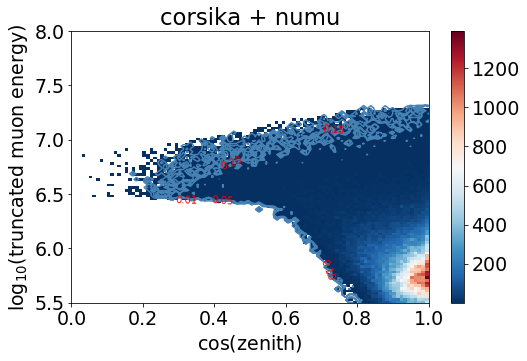

In [320]:
# ----- transform phase space ----- 
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(8,5))
h_,yy_,xx_,img_=plt.hist2d(np.concatenate((np.cos(zenith_corsika),np.cos(zenith_numu))),
            np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu))),cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=np.concatenate((weight_corsika,weight_numu_astro)),vmin = 0.001)
plt.colorbar()

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.05,0.1,0.15,0.2],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
plt.title('corsika + numu')
# plt.savefig(fig_dir + 'rf_contour_small_ineff.pdf',bbox_inches='tight')
# plt.savefig(fig_dir + 'rf_contour_small_ineff.png',dpi=300,bbox_inches='tight')
plt.show()

In [321]:
pcut1 = 5.82 # y center
pcut2 = 0.08
pcut3 = 0.95 # x center
pcut4 = 0.03

In [345]:
X = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu),8  ))
y = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu)  ))

X[:,0] = np.concatenate((chi2_red_corsika,chi2_red_numu))
X[:,1] = np.concatenate((np.log10(PeakOverMedian_corsika),np.log10(PeakOverMedian_numu))) 
X[:,2] = np.concatenate((np.cos(zenith_corsika),np.cos(zenith_numu)))
X[:,3] = np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu)))
X[:,4] = np.concatenate(( (np.log10(truncated_muon_e_corsika)-pcut1)**2/pcut2**2+(np.cos(zenith_corsika)-pcut3)**2/pcut4**2,
                          (np.log10(truncated_muon_e_numu)-pcut1)**2/pcut2**2+(np.cos(zenith_numu)-pcut3)**2/pcut4**2  ))

X[:,5] = np.concatenate((signal_dnn_corsika,signal_dnn_numu))
X[:,6] = np.concatenate((ineff_corsika,ineff_numu))

X[:,-1] = np.concatenate((weight_corsika,weight_numu_astro)) # weights. should be removed 

y = np.concatenate((np.zeros_like(chi2_red_corsika),np.ones_like(chi2_red_numu)))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)
weights_train = X_train[:,-1] * (5/4)
weights_test = X_test[:,-1] * (5/1)
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

# create classifier
clf = RandomForestClassifier(n_estimators=200,n_jobs=8)

clf.fit(X_train, y_train)
# _ = joblib.dump(clf, '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/small_ineff_region.pkl', compress = 9)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [346]:
print(X_train.shape)
print(X_test.shape)

(233600, 7)
(58401, 7)


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


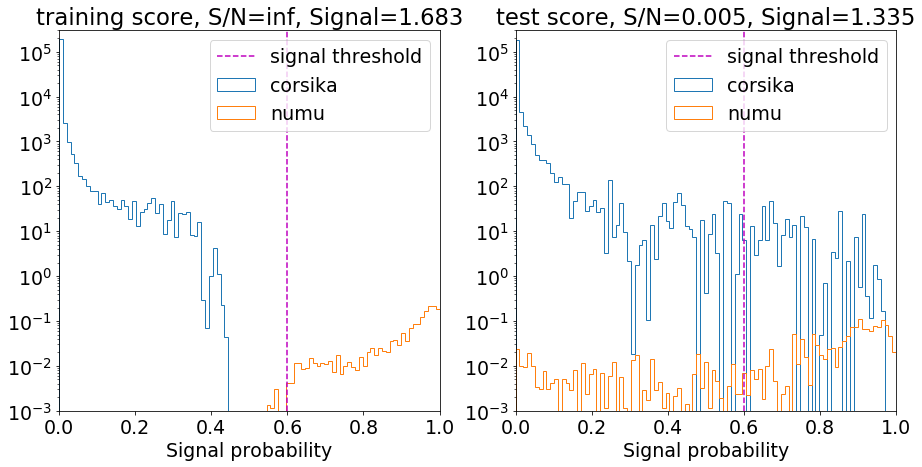

In [347]:
# training set! 
threshold = 0.6
probability_train = clf.predict_proba(X_train)[:,1]
S_N = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] ) / np.sum( (weights_train[y_train==0])[(probability_train[y_train==0])>threshold] )
Sig = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] )

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_train[y_train==0],weights=weights_train[y_train==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_train[y_train==1],weights=weights_train[y_train==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('training score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()

# test set! 
probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()
plt.xlabel('Signal probability')
# plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
# plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()

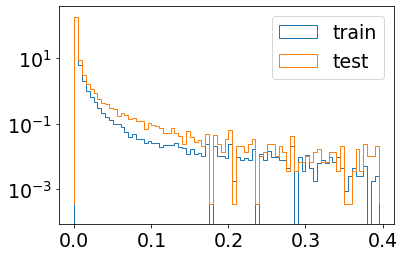

In [341]:
plt.hist(probability_train[probability_train>=0],bins=np.arange(0.,0.4,1/200),density=True,log=True,histtype='step',label='train')#,bins=np.arange(0,0.4,0.01))
plt.hist(probability_test[probability_test>=0],bins=np.arange(0.,0.4,1/200),density=True,log=True,histtype='step',label='test')#,bins=np.arange(0,0.4,0.01))

# plt.axvline(0.4)
plt.legend()
plt.show()

# Classify Burn Sample, After 2 Pulse Veto

In [348]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    ineff_data_burn = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
#     CUT_phase = (np.cos(f.root.SplineMPE.cols.zenith[:])-0.95)**2/0.03**2+\
#                 (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])-5.82)**2/0.08**2 > 1
    CUT_truncated_bin = (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])>E_min) & (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])<E_max)
    CUT_zenith = (np.cos(f.root.SplineMPE.cols.zenith[:])>Z_min)&(np.cos(f.root.SplineMPE.cols.zenith[:])<Z_max)
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 5
    CUT_untag = (f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    CUT_tag = (1 - f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) 
    
    CUT = CUT_ineff & CUT_truncated_bin & CUT_zenith & CUT_dedx & CUT_untag
    
    chi2_red_data_burn =f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    signal_dnn_data_burn = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]
    ineff_data_burn = ineff_data_burn[CUT]
    len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]


    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    
    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
    print(np.sum(weight_data_burn))
    
    run_id_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    event_id_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]

793.4170275790001


In [349]:
# Panel 
import pandas as pd 
chi2_red_cut = 0.2
pom_cut = 0.3

CUT_stoch_sig_IT_sig = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut) & passed_2_data_burn
CUT_stoch_sig_IT_bg = (chi2_red_data_burn > chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) > pom_cut) & vetoed_2_data_burn
CUT_stoch_bg_IT_sig = (chi2_red_data_burn < chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) < pom_cut) & passed_2_data_burn
CUT_stoch_bg_IT_bg = (chi2_red_data_burn < chi2_red_cut)&(np.log10(PeakOverMedian_data_burn) < pom_cut) & vetoed_2_data_burn

d11 = np.sum(weight_data_burn[CUT_stoch_bg_IT_bg])
d12 = np.sum(weight_data_burn[CUT_stoch_bg_IT_sig])
d21 = np.sum(weight_data_burn[CUT_stoch_sig_IT_bg])
d22 = np.sum(weight_data_burn[CUT_stoch_sig_IT_sig])
total = np.sum([d11,d12,d21,d22])

df = pd.DataFrame({"": ["Low Stoch", "High Stoch", "Sum"],
                   "IT vetoed": [d11/total, d21/total,(d11+d21)/total],
                   "IT passed": [d12/total, d22/total,(d12+d22)/total],
                   "Sum":       [(d11+d12)/total, (d21+d22)/total,(d11+d12+d21+d22)/total]})

# df = pd.DataFrame({"": ["Low Stoch", "High Stoch"],
#                    "IT vetoed": ["d11", "d21"],
#                    "IT passed": ["d12", "d22"]})
print('total weight of burn sample:',np.sum(weight_data_burn))
print('total weight of burn sample inside panel:',total)
df

total weight of burn sample: 793.4170275790001
total weight of burn sample inside panel: 576.4670591003672


,,IT vetoed,IT passed,Sum
0,Low Stoch,0.0,0.25448,0.25448
1,High Stoch,0.0,0.74552,0.74552
2,Sum,0.0,1.00000,1.00000


In [350]:
X = np.zeros((  len(chi2_red_data_burn),7 ))

X[:,0] = chi2_red_data_burn
X[:,1] = np.log10(PeakOverMedian_data_burn)
X[:,2] = np.cos(zenith_data_burn)
X[:,3] = np.log10(truncated_muon_e_data_burn)
X[:,4] = (np.log10(truncated_muon_e_data_burn)-pcut1)**2/pcut2**2+(np.cos(zenith_data_burn)-pcut3)**2/pcut4**2
X[:,5] = signal_dnn_data_burn
X[:,6] = ineff_data_burn

probability_data = clf.predict_proba(X)[:,1]

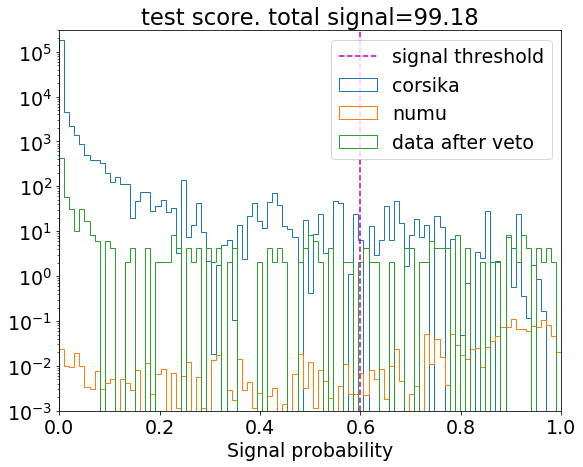

In [351]:
plt.figure(figsize=(9,7))

probability_test = clf.predict_proba(X_test)[:,1]
Sig_Tot = np.sum(weight_data_burn[probability_data>threshold])

plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
h,b,p=plt.hist(probability_data,weights=weight_data_burn,bins=np.linspace(0,1,100),histtype='step',label='data after veto',log=True,bottom=10**(-6))
# plt.plot(b[1:],h,'.',color='black')
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score. total signal='+str(np.round(Sig_Tot,2)))
plt.legend(loc='upper right')
plt.xlabel('Signal probability')
# plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
# plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()

In [352]:
print(len(probability_train[probability_train==0])/len(probability_train))
print(len(probability_test[probability_test==0])/len(probability_test))
print(len(probability_data[probability_data==0])/len(probability_data))

print(len(probability_train[probability_train==1])/len(probability_train))
print(len(probability_test[probability_test==1])/len(probability_test))
print(len(probability_data[probability_data==1])/len(probability_data))

0.9245376712328767
0.8866457766134141
0.3697916666666667
0.00022688356164383562
0.0
0.0


In [353]:
print(*run_id_data_burn[probability_data>0.9],sep=',')
print(*event_id_data_burn[probability_data>0.9],sep=',')

120201,121914,122106,122675,123096,124536,124697,124777,124938,125227,125971,126648,128846
58458196,54504729,47473816,70838028,3955552,48067242,15085072,19757945,4538343,59162578,39829990,7347684,3245


## distribution of signal and bg

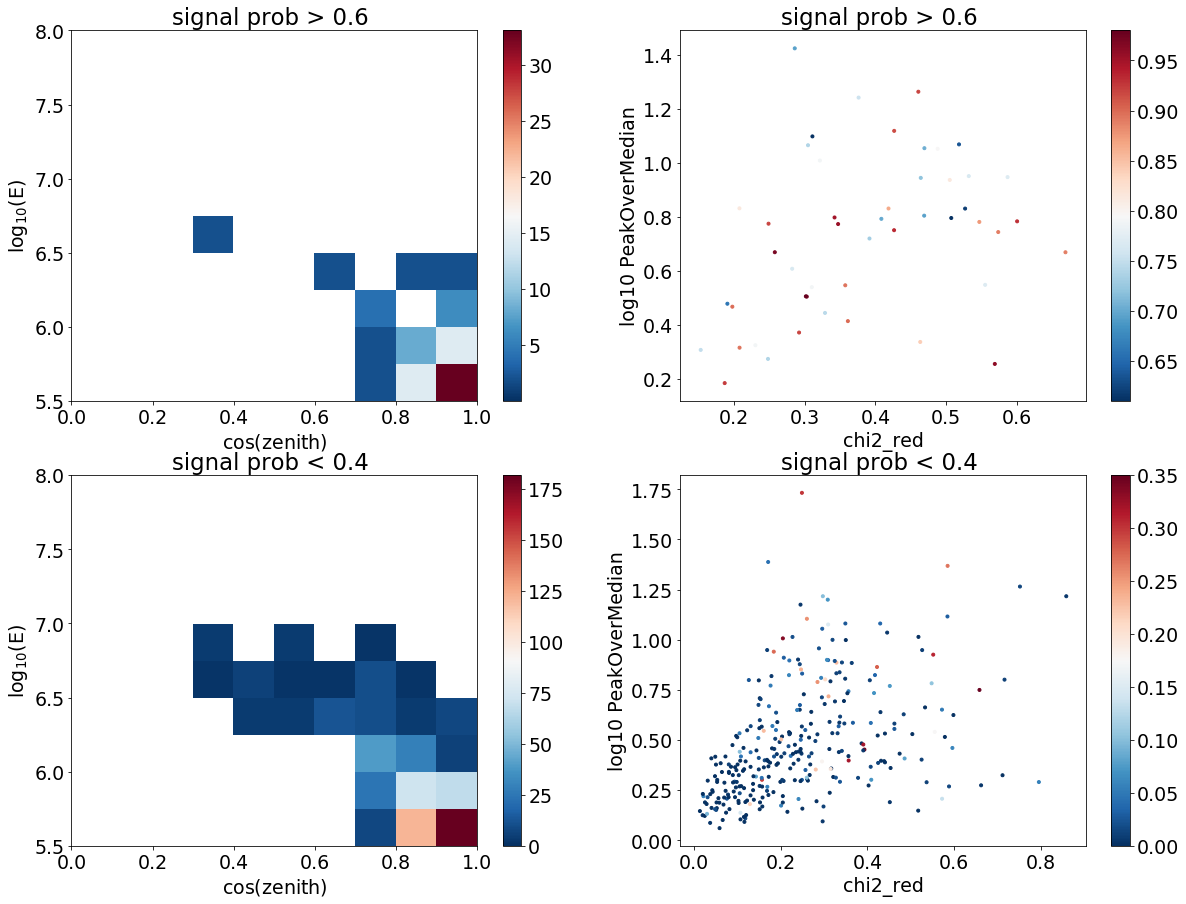

In [354]:
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(20,15))

cut_sig = probability_data > 0.6
cut_bg = probability_data < 0.4

plt.subplot(221)
h_,yy_,xx_,img_=plt.hist2d(np.cos(zenith_data_burn)[cut_sig],np.log10(truncated_muon_e_data_burn)[cut_sig],cmap=my_cmap,
            bins=10,range=[[0,1],[5.5,8]],weights=weight_data_burn[cut_sig],vmin = 1e-8)
# plt.scatter(np.cos(zenith_data_burn)[cut_sig],np.log10(truncated_muon_e_data_burn)[cut_sig],marker='.',alpha=1,c=probability_data[cut_sig],cmap='RdBu_r')
plt.colorbar()
plt.xlim(0,1)
plt.ylim(5.5,8)
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(E)')
plt.title(r'signal prob > 0.6 ')

plt.subplot(222)
plt.scatter(chi2_red_data_burn[cut_sig],np.log10(PeakOverMedian_data_burn)[cut_sig],marker='.',alpha=1,c=probability_data[cut_sig],cmap='RdBu_r') 
plt.xlabel('chi2_red')
plt.ylabel('log10 PeakOverMedian')
# plt.clim(0,1) # colorbar limit
plt.colorbar()
plt.title(r'signal prob > 0.6 ')

plt.subplot(223)
h_,yy_,xx_,img_=plt.hist2d(np.cos(zenith_data_burn)[cut_bg],np.log10(truncated_muon_e_data_burn)[cut_bg],cmap=my_cmap,
            bins=10,range=[[0,1],[5.5,8]],weights=weight_data_burn[cut_bg],vmin = 1e-8)
# plt.scatter(np.cos(zenith_data_burn)[cut_bg],np.log10(truncated_muon_e_data_burn)[cut_bg],marker='.',alpha=1,c=probability_data[cut_bg],cmap='RdBu_r')
plt.xlim(0,1)
plt.ylim(5.5,8)
plt.colorbar()
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(E)')
plt.title(r'signal prob < 0.4 ')

plt.subplot(224)
plt.scatter(chi2_red_data_burn[cut_bg],np.log10(PeakOverMedian_data_burn)[cut_bg],marker='.',alpha=1,c=probability_data[cut_bg],cmap='RdBu_r') 
plt.xlabel('chi2_red')
plt.ylabel('log10 PeakOverMedian')
# plt.clim(0,1) # colorbar limit
plt.colorbar()
plt.title(r'signal prob < 0.4 ')

plt.show()

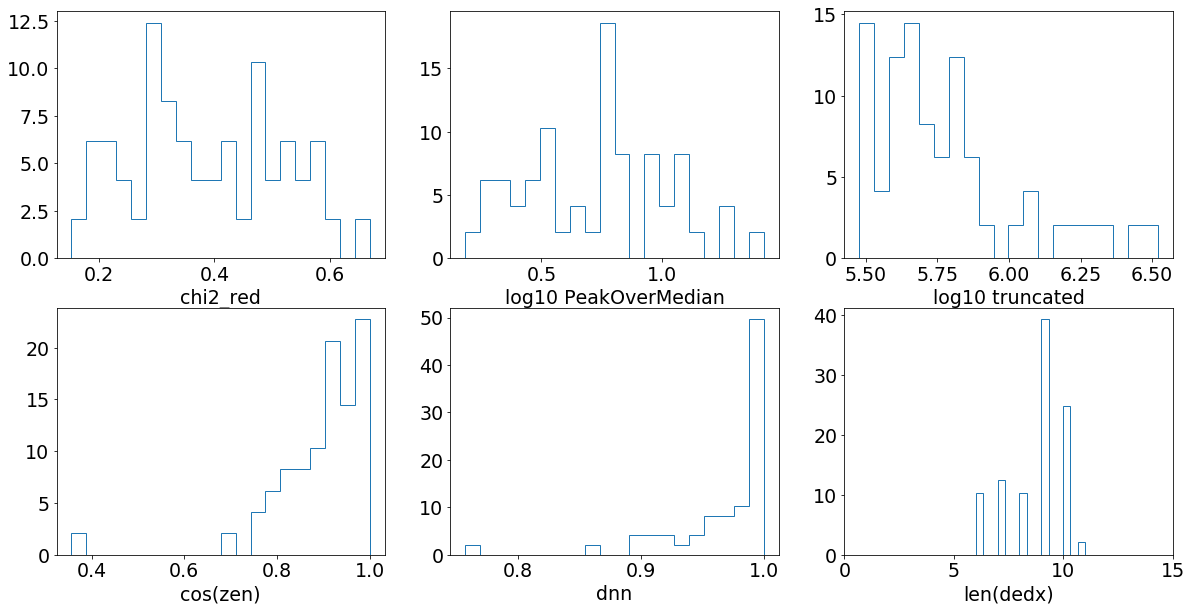

In [355]:
plt.figure(figsize=(20,10))
plt.subplot(231)
plt.hist(chi2_red_data_burn[cut_sig],weights=weight_data_burn[cut_sig],bins=20,histtype='step')
plt.xlabel('chi2_red')
plt.subplot(232)
plt.hist(np.log10(PeakOverMedian_data_burn[cut_sig]),weights=weight_data_burn[cut_sig],bins=20,histtype='step')
plt.xlabel('log10 PeakOverMedian')
plt.subplot(233)
plt.hist(np.log10(truncated_muon_e_data_burn[cut_sig]),weights=weight_data_burn[cut_sig],bins=20,histtype='step')
plt.xlabel('log10 truncated')
plt.subplot(234)
plt.hist(np.cos(zenith_data_burn[cut_sig]),weights=weight_data_burn[cut_sig],bins=20,histtype='step')
plt.xlabel('cos(zen)')
plt.subplot(235)
plt.hist(signal_dnn_data_burn[cut_sig],weights=weight_data_burn[cut_sig],bins=20,histtype='step')
plt.xlabel('dnn')
plt.subplot(236)
plt.hist(len_dedx_data_burn[cut_sig],weights=weight_data_burn[cut_sig],bins=15,histtype='step')
plt.xlim(0,15)
plt.xlabel('len(dedx)')
plt.show()

In [356]:
# low sig high stoch
print(*run_id_data_burn[(probability_data<0.001)&(chi2_red_data_burn>0.3)&(np.log10(PeakOverMedian_data_burn)>0.4)],sep=',')
print(*event_id_data_burn[(probability_data<0.001)&(chi2_red_data_burn>0.3)&(np.log10(PeakOverMedian_data_burn)>0.4)],sep=',')


121767,122234,122374,123380,124098,125335,126001,126639,126836,126893,126950,127215,127352,127475,128977
61920578,25887885,55570365,69871651,36936559,59675931,9222082,29494873,47754621,11205540,44074200,11306971,36481720,10801267,53615594


In [357]:
# high sig low stoch
print(*run_id_data_burn[(probability_data>0.6)&(chi2_red_data_burn<0.2)&(np.log10(PeakOverMedian_data_burn)<0.2)],sep=',')
print(*event_id_data_burn[(probability_data>0.6)&(chi2_red_data_burn<0.2)&(np.log10(PeakOverMedian_data_burn)<0.2)],sep=',')

124536
48067242


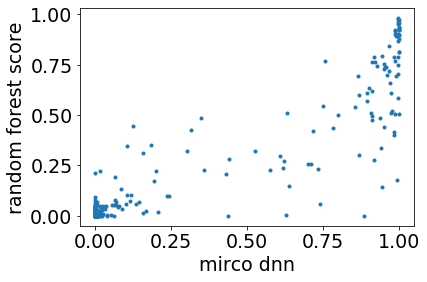

In [358]:
plt.plot(signal_dnn_data_burn,probability_data,'.')
plt.xlabel('mirco dnn')
plt.ylabel('random forest score')
plt.show()

# Background Estimation

In [711]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    ineff_data_burn = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
#     CUT_phase = (np.cos(f.root.SplineMPE.cols.zenith[:])-0.95)**2/0.03**2+\
#                 (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])-5.82)**2/0.08**2 > 1
#     CUT_truncated_bin = (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])>E_min) & (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])<E_max)
#     CUT_zenith = (np.cos(f.root.SplineMPE.cols.zenith[:])>Z_min)&(np.cos(f.root.SplineMPE.cols.zenith[:])<Z_max)
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 5
    CUT_untag = (f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    CUT_tag = (1 - f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) 
    
    CUT = CUT_ineff & CUT_truncated_bin & CUT_zenith & CUT_dedx # & CUT_untag
    
    chi2_red_data_burn =f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    signal_dnn_data_burn = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]
    ineff_data_burn = ineff_data_burn[CUT]
    len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    
    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
    print(np.sum(weight_data_burn))
    
    run_id_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    event_id_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]

181415.6298320087


In [712]:
X = np.zeros((  len(chi2_red_data_burn),7 ))

X[:,0] = chi2_red_data_burn
X[:,1] = np.log10(PeakOverMedian_data_burn)
X[:,2] = np.cos(zenith_data_burn)
X[:,3] = np.log10(truncated_muon_e_data_burn)
X[:,4] = (np.log10(truncated_muon_e_data_burn)-pcut1)**2/pcut2**2+(np.cos(zenith_data_burn)-pcut3)**2/pcut4**2
X[:,5] = signal_dnn_data_burn
X[:,6] = ineff_data_burn

probability_data = clf.predict_proba(X)[:,1]

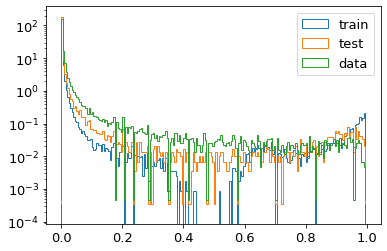

In [713]:
plt.hist(probability_train[probability_train>=0],bins=np.arange(0.,1,1/200),density=True,log=True,histtype='step',label='train')#,bins=np.arange(0,1,0.01))
plt.hist(probability_test[probability_test>=0],bins=np.arange(0.,1,1/200),density=True,log=True,histtype='step',label='test')#,bins=np.arange(0,1,0.01))
plt.hist(probability_data[probability_data>=0],bins=np.arange(0.,1,1/200),density=True,log=True,histtype='step',label='data')#,bins=np.arange(0,1,0.01))
# plt.axvline(0.4)
plt.legend()
plt.show()

In [720]:
(np.cos(zenith_data_burn)>=zen_bins[i]) & (np.cos(zenith_data_burn)<zen_bins[i+1])

array([False, False, False, ..., False, False, False])

In [791]:
np.sum(weight_data_burn[probability_data>0.6])

1514.517398998456

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10


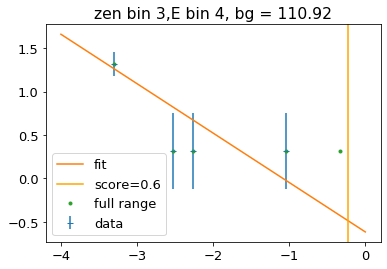

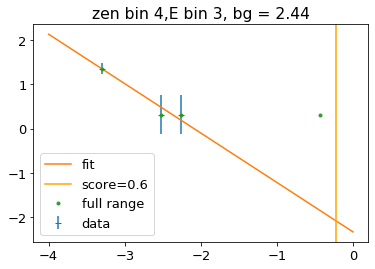

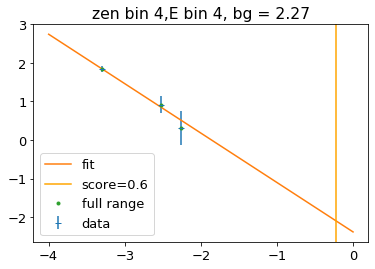

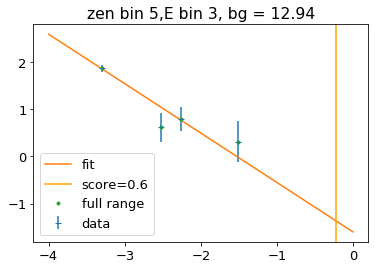

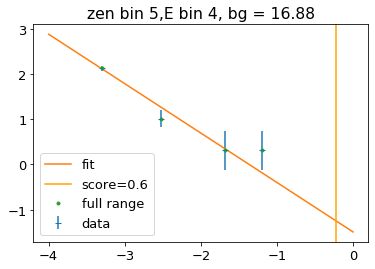

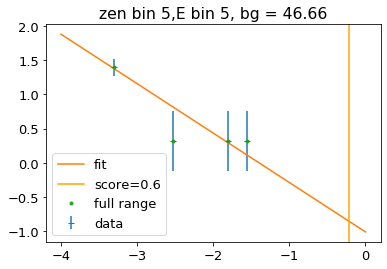

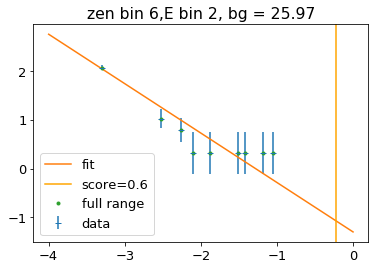

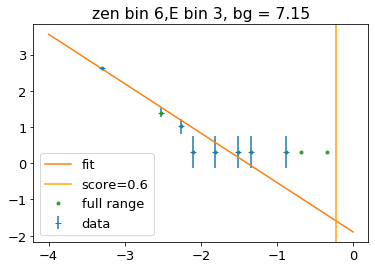

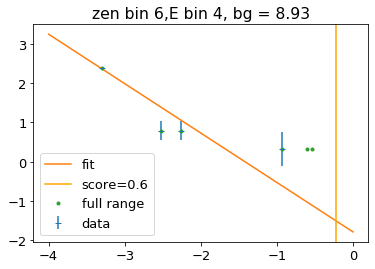

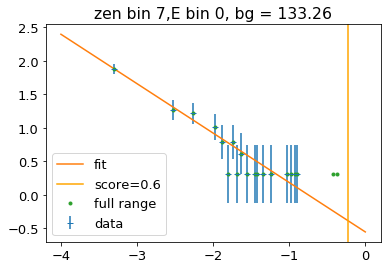

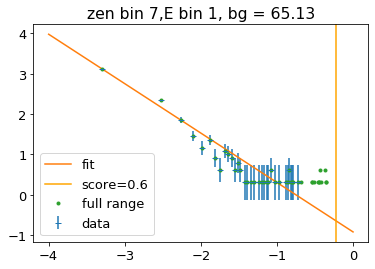

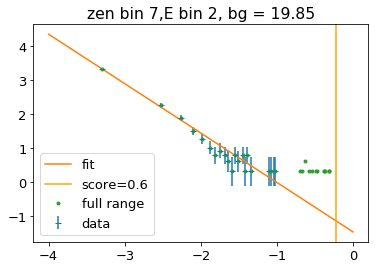

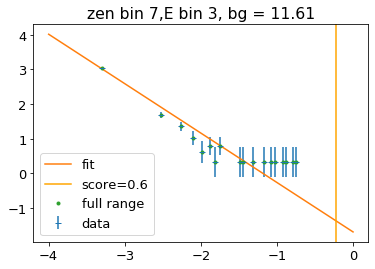

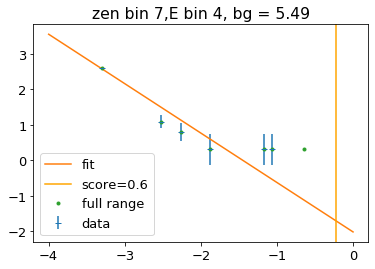

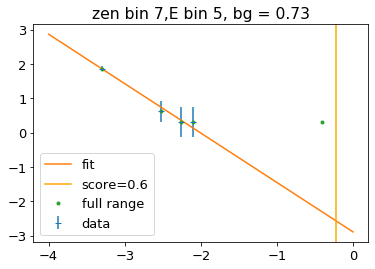

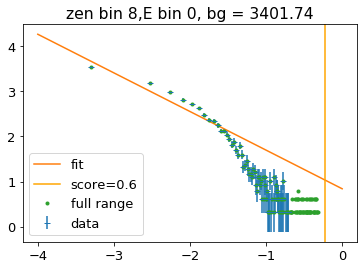

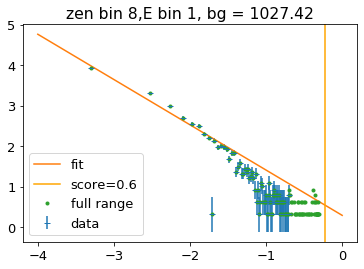

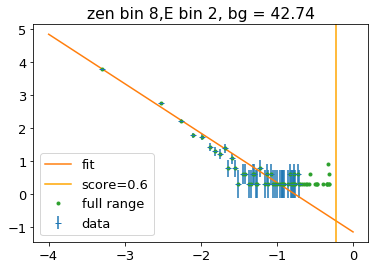

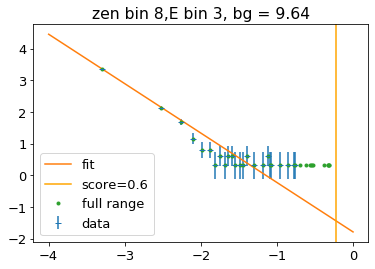

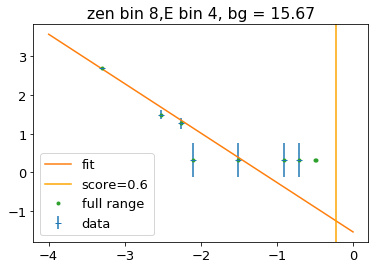

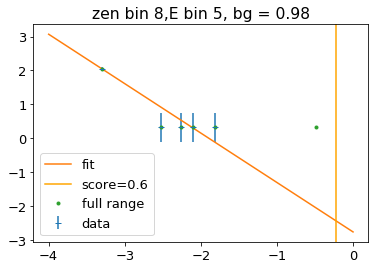

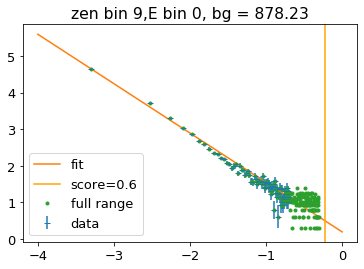

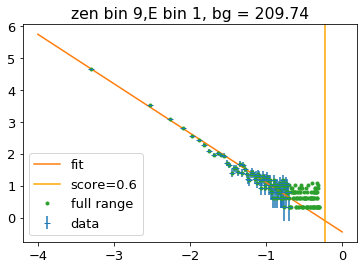

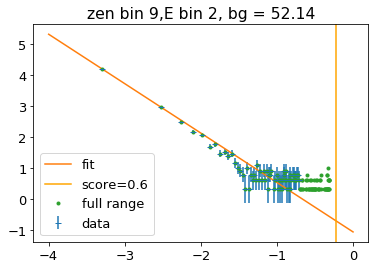

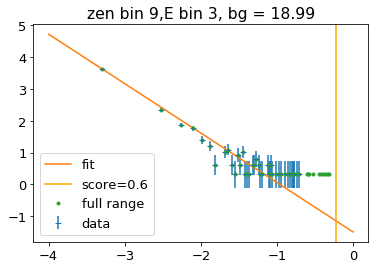

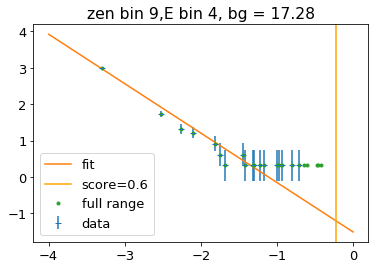

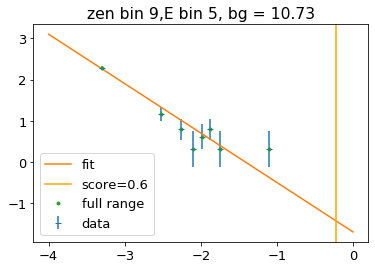

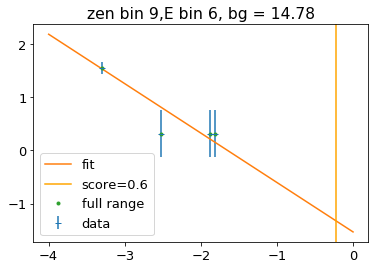

6170.313314414198


In [823]:
def f(x,a,b):
    return a*x + b # prediction in loglog space. y=x^a+b. Robust! 

total_bg_in_sig_region = 0

zen_bins = np.arange(0,1.1,0.1)
e_bins = np.arange(5.5,8.25,0.25)

for i in range(0,len(zen_bins)-1):
    for j in range(0,len(e_bins)-1):
        sampling_step = 0.001

        cut_zen = (np.cos(zenith_data_burn)>zen_bins[i]) & (np.cos(zenith_data_burn)<=zen_bins[i+1])
        cut_e = (np.log10(truncated_muon_e_data_burn)>e_bins[j]) & (np.log10(truncated_muon_e_data_burn)<=e_bins[j+1])
        h,b = np.histogram(probability_data[cut_zen&cut_e],bins=np.arange(0,0.4,sampling_step),weights=weight_data_burn[cut_zen&cut_e])    
        b = (b[:1]+b[1:])/2
        
        h_all,b_all = np.histogram(probability_data[cut_zen&cut_e],bins=np.arange(0,1,sampling_step),weights=weight_data_burn[cut_zen&cut_e])    
        b_all = (b_all[:1]+b_all[1:])/2

        # only fit nonzero pts 
        b = b[h>0]
        h = h[h>0]

        if len(h)>=3:
            popt,pcov = curve_fit(f,np.log10(b),np.log10(h),sigma=1/np.log(10)*1/h*np.sqrt(h)*np.sqrt(weight_data_burn[0]))

            # calculate bg 
            bg_region = np.arange(0.6,1,sig_step)
            bg_in_bin = 10**f(np.log10(bg_region),*popt)
            total_bg = np.sum(bg_in_bin)
            
            plt.figure()
            t = np.arange(0,1,0.0001)
            plt.errorbar(np.log10(b),np.log10(h),yerr=1/np.log(10)*1/h*np.sqrt(h)*np.sqrt(weight_data_burn[0]),fmt='_',label='data')
            plt.plot(np.log10(t), f(np.log10(t),*popt),label='fit')
            plt.axvline(np.log10(0.6),color='orange',label='score=0.6')

            plt.plot(np.log10(b_all),np.log10(h_all),'.',label='full range')
            plt.title('zen bin '+str(i)+',E bin '+str(j)+', bg = '+str(np.round(total_bg,2)))
            plt.legend()
            plt.show()
            
        else:
            total_bg = 0
            
        total_bg_in_sig_region+=total_bg
        
print(total_bg_in_sig_region)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


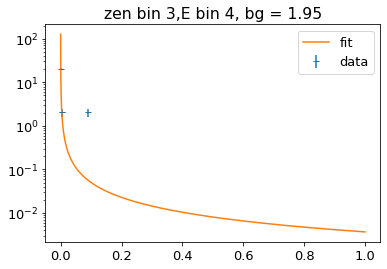

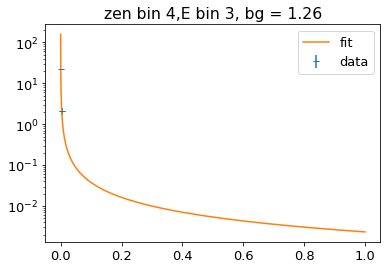

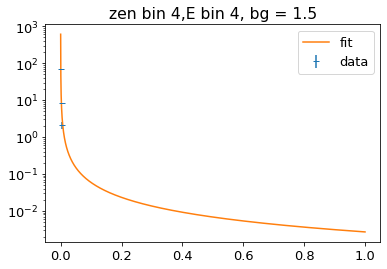

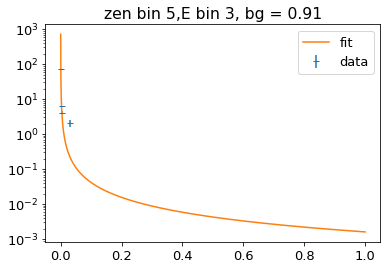

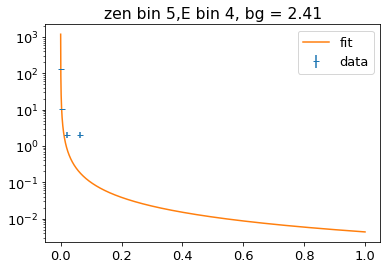

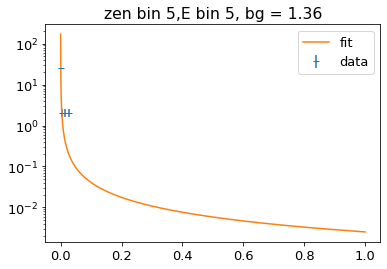

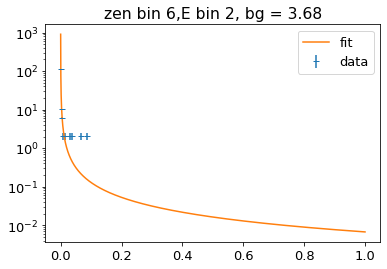

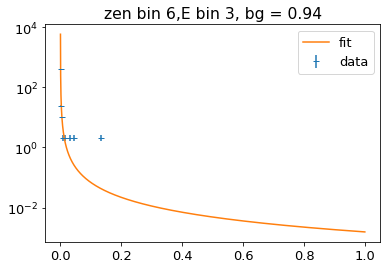

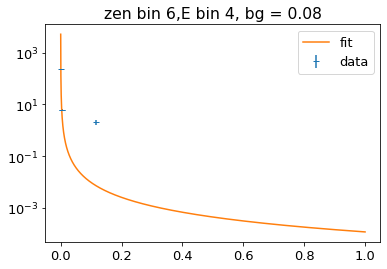

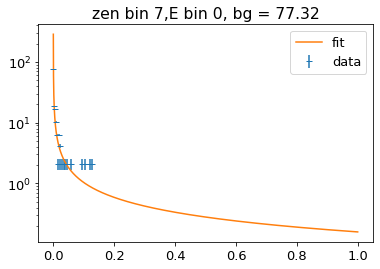

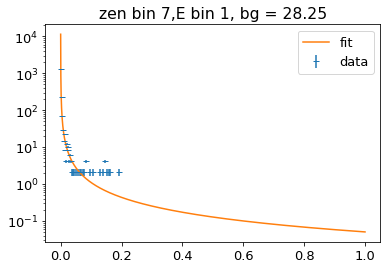

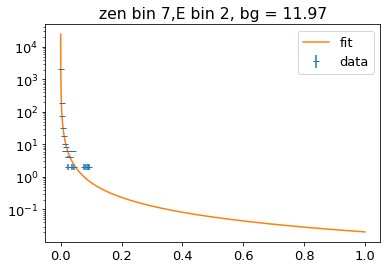

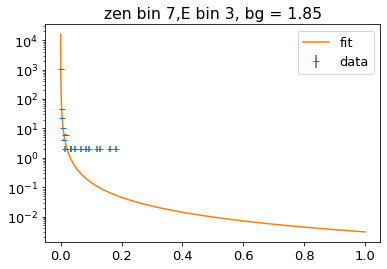

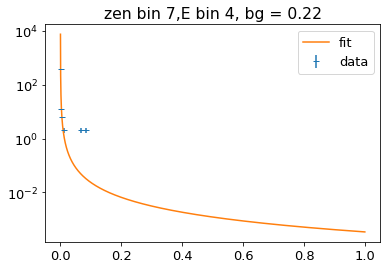

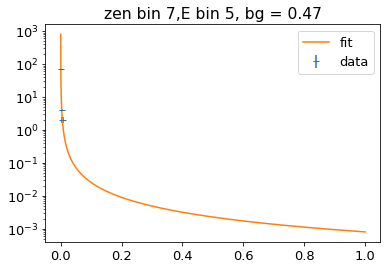

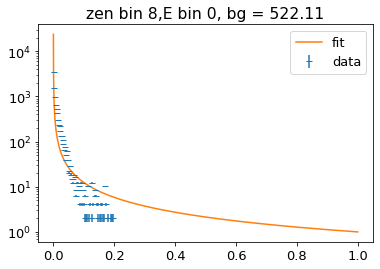

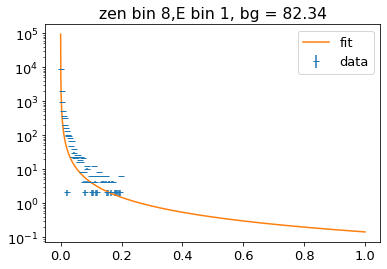

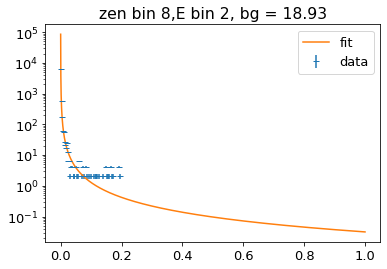

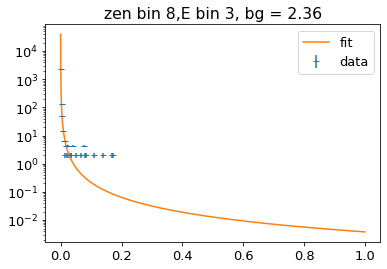

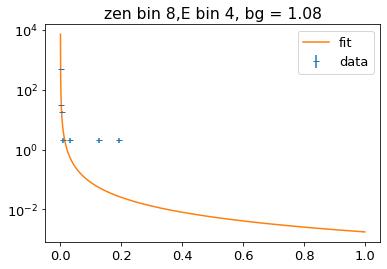

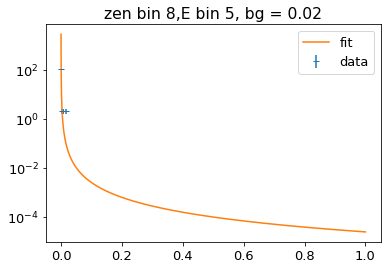

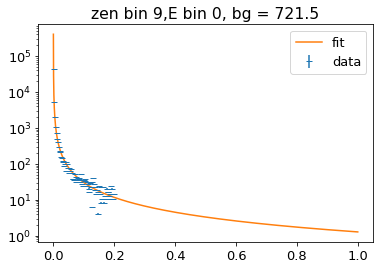

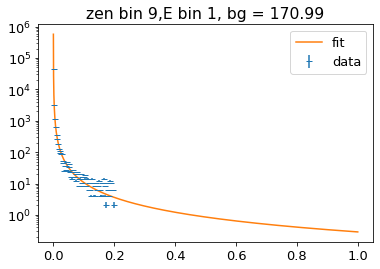

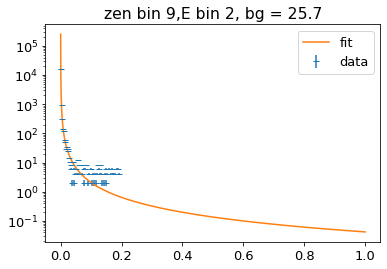

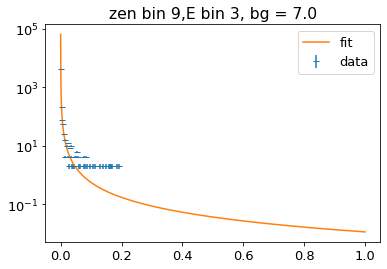

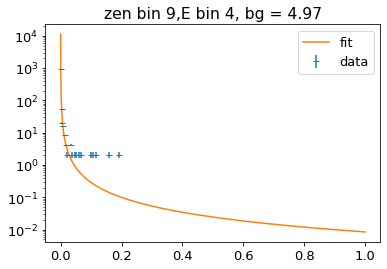

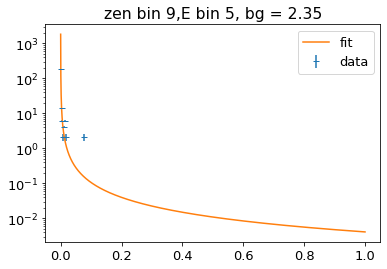

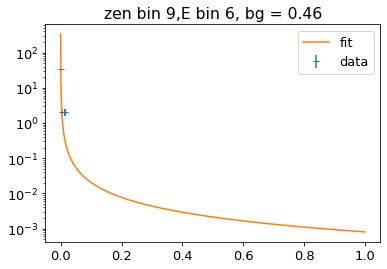

1693.9803321411086


In [822]:
### debugging, without in log space  ### 
def f(x,a,b,c):
    return a*1/x**b
#     return a*x + b # prediction in loglog space. y=x^a+b. Robust! 

total_bg_in_sig_region = 0

zen_bins = np.arange(0,1.1,0.1)
e_bins = np.arange(5.5,8.25,0.25)

for i in range(0,len(zen_bins)-1):
    for j in range(0,len(e_bins)-1):
        sampling_step = 0.001

        cut_zen = (np.cos(zenith_data_burn)>zen_bins[i]) & (np.cos(zenith_data_burn)<=zen_bins[i+1])
        cut_e = (np.log10(truncated_muon_e_data_burn)>e_bins[j]) & (np.log10(truncated_muon_e_data_burn)<=e_bins[j+1])
        h,b = np.histogram(probability_data[cut_zen&cut_e],bins=np.arange(0,0.4,sampling_step),weights=weight_data_burn[cut_zen&cut_e])    
        b = (b[:1]+b[1:])/2
        
        h_all,b_all = np.histogram(probability_data[cut_zen&cut_e],bins=np.arange(0,1,sampling_step),weights=weight_data_burn[cut_zen&cut_e])    
        b_all = (b_all[:1]+b_all[1:])/2

        # only fit nonzero pts 
        b = b[h>0]
        h = h[h>0]

        if len(h)>=3:
            try:
                popt,pcov = curve_fit(f,b,h,sigma=np.sqrt(h)*np.sqrt(weight_data_burn[0]))
            except: 
                popt = np.array([0,0,0])
            # calculate bg 
            bg_region = np.arange(0.6,1,sig_step)
            bg_in_bin = f(bg_region,*popt)
            total_bg = np.sum(bg_in_bin)
            
            plt.figure()
            t = np.arange(0,1,0.0001)
            plt.errorbar(b,h,yerr=1/np.log(10)*1/h*np.sqrt(h)*np.sqrt(weight_data_burn[0]),fmt='_',label='data')
            plt.semilogy(t,f(t,*popt),label='fit')
#             plt.axvline(np.log10(0.6),color='orange',label='score=0.6')

#             plt.plot(np.log10(b_all),np.log10(h_all),'.',label='full range')
            plt.title('zen bin '+str(i)+',E bin '+str(j)+', bg = '+str(np.round(total_bg,2)))
            plt.legend()
            plt.show()
            
        else:
            total_bg = 0
            
        total_bg_in_sig_region+=total_bg
        
print(total_bg_in_sig_region)

400


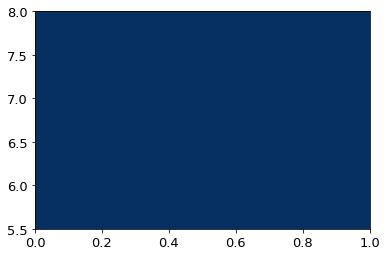

In [801]:
# ----- make hist for each rf score bin -----
plt.rcParams.update({'font.size': 13})
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

# plt.figure(figsize=(18,18))

Signal = np.arange(0,0.4,0.001)
print(len(Signal))
H = []

for i in range(0,len(Signal)-1):
#     plt.subplot(3,3,i+1)
#     plt.figure()
    cut_score = (probability_data >= Signal[i])&(probability_data < Signal[i+1])# & (probability_data>0) # CAREFUL!!
    h_,xx_,yy_,img_=plt.hist2d(np.cos(zenith_data_burn)[cut_score],np.log10(truncated_muon_e_data_burn)[cut_score],cmap=my_cmap,
                bins=10,range=[[0,1],[5.5,8]],weights=weight_data_burn[cut_score])
#     plt.colorbar()    
#     plt.xlabel(r'$\cos$(zenith)')
#     plt.ylabel(r'$\log_{10}$(E)')
#     plt.title(r'signal prob $\in$['+str(np.round(Signal[i],3))+','+str(np.round(Signal[i+1],3))+']')
#     plt.show()
    H.append(h_)
Signal = Signal[1:]
H = np.array(H)

# plt.suptitle('data burn')
# plt.savefig(fig_dir + 'rf_contour_small_ineff.pdf',bbox_inches='tight')
# plt.savefig(fig_dir + 'rf_contour_small_ineff.png',dpi=300,bbox_inches='tight')
# plt.show()

In [802]:
def find_bg(e_bin,z_bin): # return signal in E_zen bin in signal region 
    n = []
    for i in range(0,len(H)):
        n = np.append(n, H[i][e_bin,z_bin])
    
    if len(n[n>0])>=3:
        def f(x,a,b):
            return a*x + b # prediction in loglog space. y=x^a+b. Robust! 

        popt,pcov = curve_fit(f,np.log10(Signal[n>0]),np.log10(n[n>0]),sigma=1/np.log(10)*1/n[n>0]*np.sqrt(n[n>0])*np.sqrt(weight_data_burn[0]))#,bounds = ([-3,3]))

        sig_step = 0.001

        signal_region = np.arange(0.6,1,sig_step)
        signal_in_bin = 10**f(np.log10(signal_region),*popt)
        total_signal = np.sum(signal_in_bin)

        return total_signal
    else:
        return 0
    
# print(find_bg(9,0))

total_bg = 0
for i in range(0,10):
    for j in range(0,10):
        bg = find_bg(i,j)
        total_bg+=bg
print(total_bg)


12627.516973374237


164.58718894719124
[-0.56937328 -0.44514481] 3 4


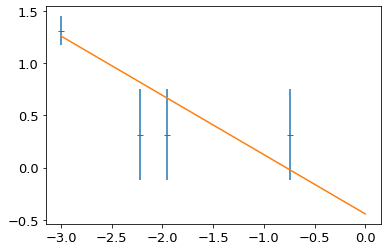

5.286940141236327
[-1.11704294 -1.99843328] 4 3


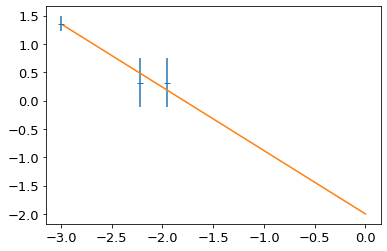

5.526695973116154
[-1.28215601 -1.99784654] 4 4


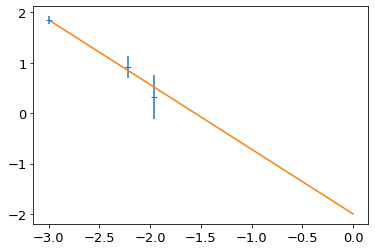

26.762520079543343
[-1.04846604 -1.2864303 ] 5 3


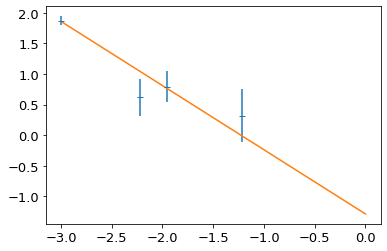

35.994889717627345
[-1.09281972 -1.16267883] 5 4


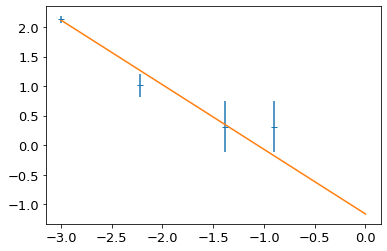

76.92356444224214
[-0.72117868 -0.79185539] 5 5


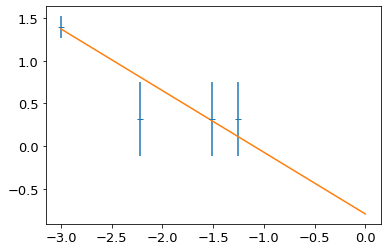

52.306969291972706
[-1.01000753 -0.99110999] 6 2


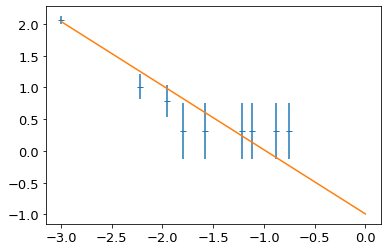

18.39546897014842
[-1.3636517  -1.48491343] 6 3


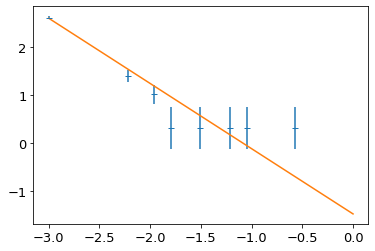

21.35472673061281
[-1.25784494 -1.40805232] 6 4


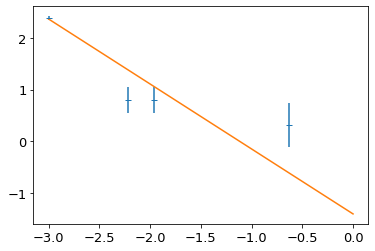

222.34672805460258
[-0.73857494 -0.33277434] 7 0


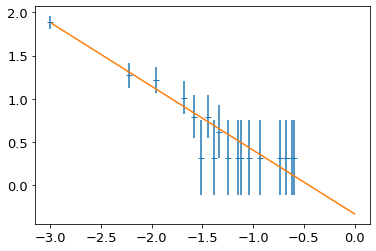

152.2785923620632
[-1.22527658 -0.55121106] 7 1


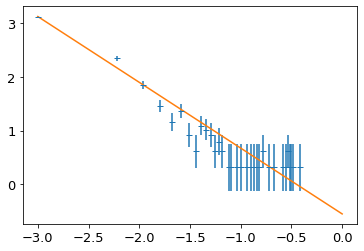

54.22239623857875
[-1.44965167 -1.02534044] 7 2


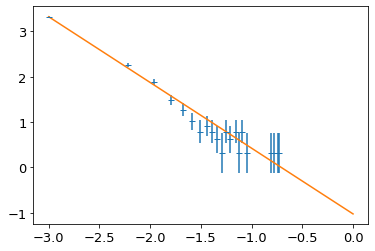

31.21390693140875
[-1.42716712 -1.26257729] 7 3


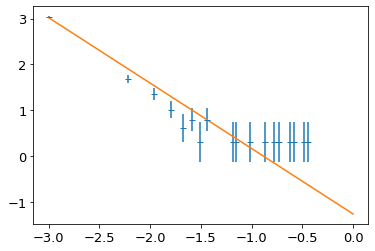

14.420717236503119
[-1.39206632 -1.593899  ] 7 4


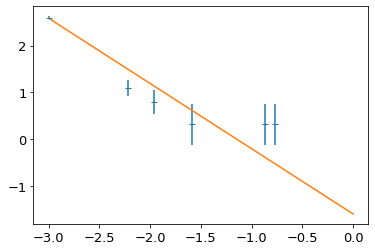

1.9780088260795834
[-1.43959152 -2.46212983] 7 5


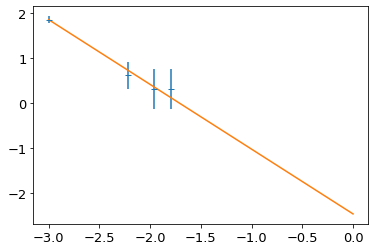

6163.861221404424
[-0.85756291  1.09704182] 8 0


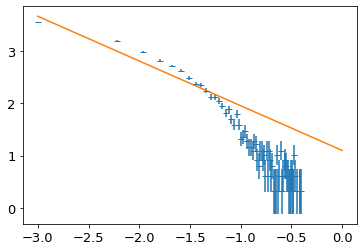

2230.224557301987
[-1.11816109  0.62658532] 8 1


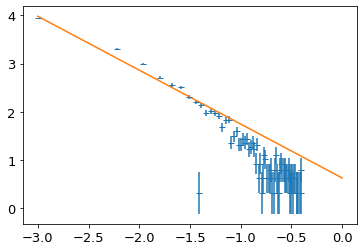

120.62739492144905
[-1.49701124 -0.68355201] 8 2


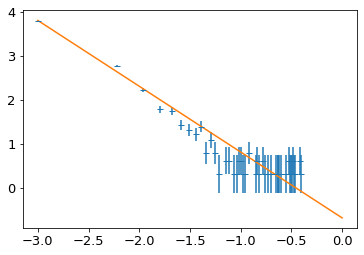

28.439182458742113
[-1.56088948 -1.31850412] 8 3


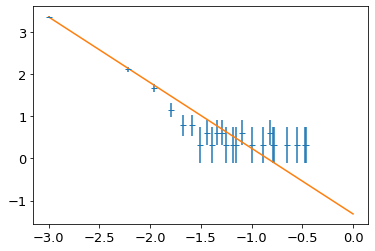

38.07255984537631
[-1.28034755 -1.15949411] 8 4


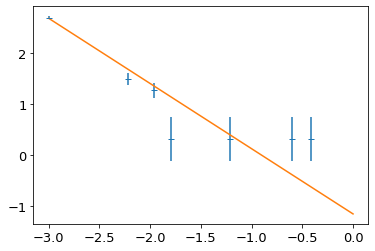

2.6985773394272936
[-1.45959033 -2.32953228] 8 5


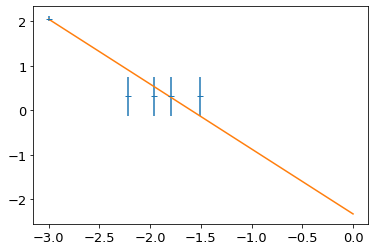

2236.797160325986
[-1.34876328  0.60170823] 9 0


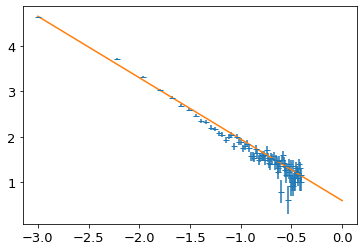

612.6830891208447
[-1.54651463  0.01648852] 9 1


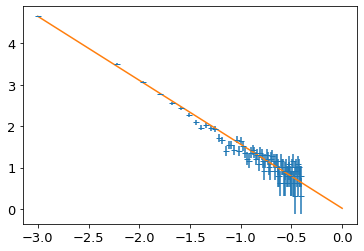

157.71932799467908
[-1.59678879 -0.57872502] 9 2


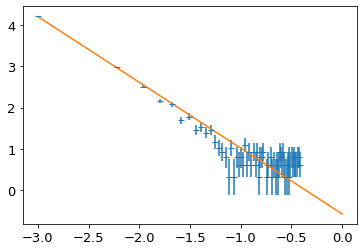

55.73043826952957
[-1.55306518 -1.02541744] 9 3


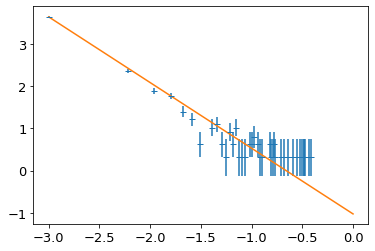

44.29865336557161
[-1.35819375 -1.10260816] 9 4


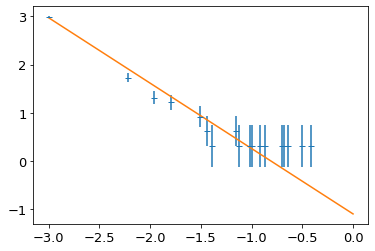

24.652244113804436
[-1.20023486 -1.33915809] 9 5


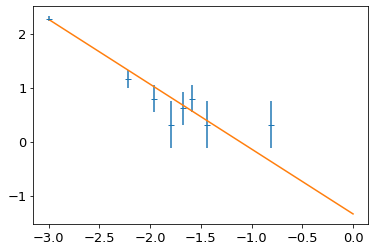

28.11325296949176
[-0.92787955 -1.2516488 ] 9 6


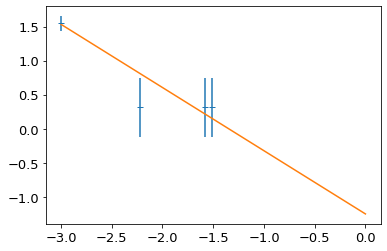

In [803]:
#################### testing here ####################

def f(x,a,b):
#     return a*np.exp(-b*x)+c
#     return a*10**(1/x**b+c)
#     return a*1/x**b+c # equivalent to this 
#     return a*np.exp(-b*x)+c
#     return a*x**2 + b*x+c
    return a*x + b # prediction in loglog space. y=x^a+b. Robust! 

def find_hist(e_bin,z_bin):    
    n = []
    for i in range(0,len(H)):
        n=np.append(n,H[i][e_bin,z_bin])
    return n

def do_fitting(e_bin,z_bin):
    global total_bg_in_sig_region

    popt,pcov = curve_fit(f,np.log10(Signal[n>0]),np.log10(n[n>0]),sigma=1/np.log(10)*1/n[n>0]*np.sqrt(n[n>0])*np.sqrt(weight_data_burn[0]))#,bounds = ([-3,3]))

    sig_step = 0.001

    signal_region = np.arange(0.6,1,sig_step)
    signal_in_bin = 10**f(np.log10(signal_region),*popt)
    total_signal = np.sum(signal_in_bin)
    print(total_signal)
    total_bg_in_sig_region.append(total_signal)
    return popt

total_bg_in_sig_region = []

t = np.logspace(-3,0,100)

for i in range(0,10):
    for j in range(0,10):
        n = find_hist(i,j)
        if len(n[n>0])>=3:
            popt = do_fitting(i,j)
            print(popt,i,j)
                
            plt.errorbar(np.log10(Signal[n>0]),np.log10(n[n>0]),yerr=1/np.log(10)*1/n[n>0]*np.sqrt(n[n>0])*np.sqrt(weight_data_burn[0]),fmt='_')
            plt.plot(np.log10(t), f(np.log10(t),*popt))
    #         plt.ylim(0,100)

            plt.show()

In [804]:
total_bg_in_sig_region

[164.58718894719124,
 5.286940141236327,
 5.526695973116154,
 26.762520079543343,
 35.994889717627345,
 76.92356444224214,
 52.306969291972706,
 18.39546897014842,
 21.35472673061281,
 222.34672805460258,
 152.2785923620632,
 54.22239623857875,
 31.21390693140875,
 14.420717236503119,
 1.9780088260795834,
 6163.861221404424,
 2230.224557301987,
 120.62739492144905,
 28.439182458742113,
 38.07255984537631,
 2.6985773394272936,
 2236.797160325986,
 612.6830891208447,
 157.71932799467908,
 55.73043826952957,
 44.29865336557161,
 24.652244113804436,
 28.11325296949176]

In [805]:
np.sum(total_bg_in_sig_region)

12627.516973374237

In [809]:
np.sum(10**f(np.log10(signal_region),*popt))

28.11325296949176

# If just use stochasticity vars, which feature is important??

In [55]:
IT_ineff_cut = 0.01

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11937.h5','r') as f:
    n_file = 100000 # with _rf, the size of broken file is 266K instead of 0! 
    
    ineff_corsika = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_corsika < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4

    CUT = CUT_ineff & CUT_dedx

    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]

    
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file # * 903098/363528
    print(np.sum(weight_corsika))
    

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 19999

    ineff_numu = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_numu < IT_ineff_cut

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 5

    CUT = CUT_ineff & CUT_dedx
    
    chi2_red_numu = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


209281.96658175907


## 1. chi2_red and pom

In [62]:
X = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu),3  ))
y = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu)  ))

X[:,0] = np.concatenate((chi2_red_corsika,chi2_red_numu))
X[:,1] = np.concatenate((np.log10(PeakOverMedian_corsika),np.log10(PeakOverMedian_numu))) 

X[:,-1] = np.concatenate((weight_corsika,weight_numu_astro)) # weights. should be removed 

y = np.concatenate((np.zeros_like(chi2_red_corsika),np.ones_like(chi2_red_numu)))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state=42)
weights_train = X_train[:,-1] * (2)
weights_test = X_test[:,-1] * (2)
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

# create classifier
clf = RandomForestClassifier(n_estimators=200,n_jobs=8,max_depth=10)

clf.fit(X_train, y_train)
# _ = joblib.dump(clf, '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/small_ineff_region.pkl', compress = 9)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


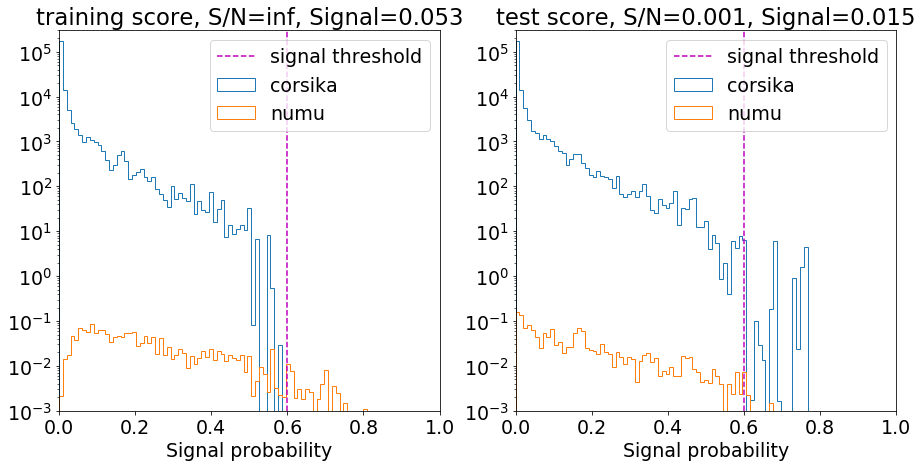

In [63]:
# training set! 
threshold = 0.6
probability_train = clf.predict_proba(X_train)[:,1]
S_N = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] ) / np.sum( (weights_train[y_train==0])[(probability_train[y_train==0])>threshold] )
Sig = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] )

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_train[y_train==0],weights=weights_train[y_train==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_train[y_train==1],weights=weights_train[y_train==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('training score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()

# test set! 
probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()
plt.xlabel('Signal probability')
# plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
# plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()

## 2. chi2_red only

In [66]:
X = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu),2  ))
y = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu)  ))

X[:,0] = np.concatenate((chi2_red_corsika,chi2_red_numu))

X[:,-1] = np.concatenate((weight_corsika,weight_numu_astro)) # weights. should be removed 

y = np.concatenate((np.zeros_like(chi2_red_corsika),np.ones_like(chi2_red_numu)))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state=42)
weights_train = X_train[:,-1] * (2)
weights_test = X_test[:,-1] * (2)
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

# create classifier
clf = RandomForestClassifier(n_estimators=200,n_jobs=8,max_depth=12)

clf.fit(X_train, y_train)
# _ = joblib.dump(clf, '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/small_ineff_region.pkl', compress = 9)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


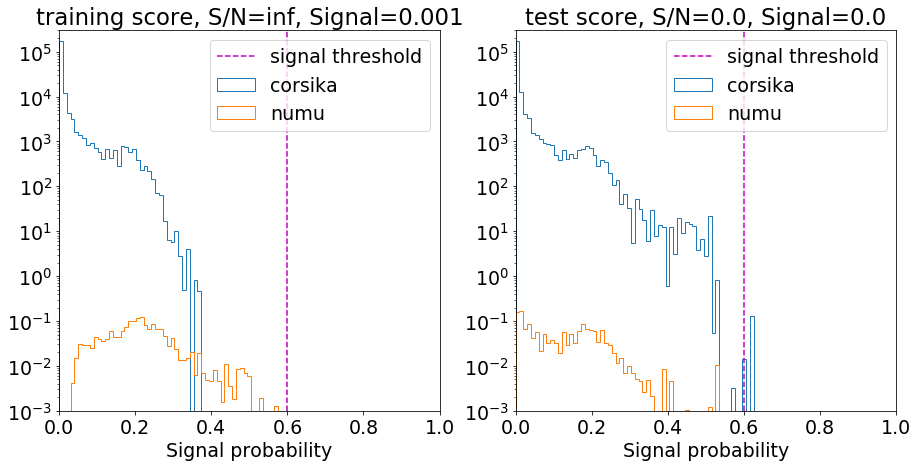

In [67]:
# training set! 
threshold = 0.6
probability_train = clf.predict_proba(X_train)[:,1]
S_N = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] ) / np.sum( (weights_train[y_train==0])[(probability_train[y_train==0])>threshold] )
Sig = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] )

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_train[y_train==0],weights=weights_train[y_train==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_train[y_train==1],weights=weights_train[y_train==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('training score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()

# test set! 
probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()
plt.xlabel('Signal probability')
# plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
# plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()

## 3. peakovermedian only

In [68]:
X = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu),2  ))
y = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu)  ))

X[:,0] = np.concatenate((np.log10(PeakOverMedian_corsika),np.log10(PeakOverMedian_numu))) 

X[:,-1] = np.concatenate((weight_corsika,weight_numu_astro)) # weights. should be removed 

y = np.concatenate((np.zeros_like(chi2_red_corsika),np.ones_like(chi2_red_numu)))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state=42)
weights_train = X_train[:,-1] * (2)
weights_test = X_test[:,-1] * (2)
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

# create classifier
clf = RandomForestClassifier(n_estimators=200,n_jobs=8,max_depth=8)

clf.fit(X_train, y_train)
# _ = joblib.dump(clf, '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/small_ineff_region.pkl', compress = 9)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

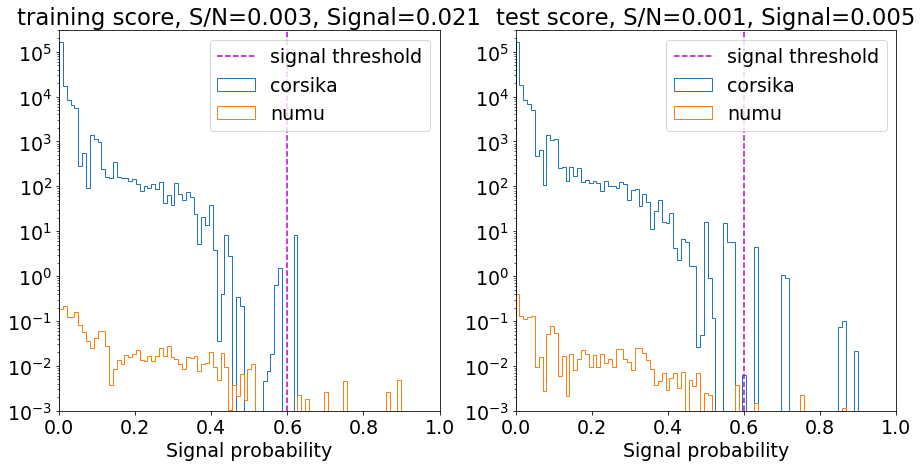

In [69]:
# training set! 
threshold = 0.6
probability_train = clf.predict_proba(X_train)[:,1]
S_N = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] ) / np.sum( (weights_train[y_train==0])[(probability_train[y_train==0])>threshold] )
Sig = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] )

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_train[y_train==0],weights=weights_train[y_train==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_train[y_train==1],weights=weights_train[y_train==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('training score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()

# test set! 
probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()
plt.xlabel('Signal probability')
# plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
# plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()

## 3. new chi2 only

In [70]:
stoch_corsika = np.sqrt(chi2_red_corsika**2 + np.log10(PeakOverMedian_corsika)**2/4)
stoch_numu = np.sqrt(chi2_red_numu**2 + np.log10(PeakOverMedian_numu)**2/4)

In [71]:
X = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu),2  ))
y = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu)  ))

X[:,0] = np.concatenate((stoch_corsika,stoch_numu)) 

X[:,-1] = np.concatenate((weight_corsika,weight_numu_astro)) # weights. should be removed 

y = np.concatenate((np.zeros_like(chi2_red_corsika),np.ones_like(chi2_red_numu)))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state=42)
weights_train = X_train[:,-1] * (2)
weights_test = X_test[:,-1] * (2)
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

# create classifier
clf = RandomForestClassifier(n_estimators=200,n_jobs=8,max_depth=8)

clf.fit(X_train, y_train)
# _ = joblib.dump(clf, '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/small_ineff_region.pkl', compress = 9)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


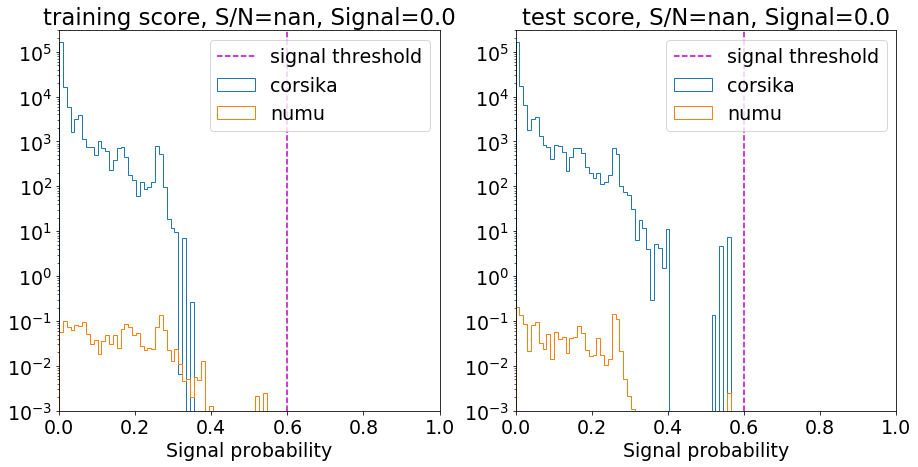

In [72]:
# training set! 
threshold = 0.6
probability_train = clf.predict_proba(X_train)[:,1]
S_N = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] ) / np.sum( (weights_train[y_train==0])[(probability_train[y_train==0])>threshold] )
Sig = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] )

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_train[y_train==0],weights=weights_train[y_train==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_train[y_train==1],weights=weights_train[y_train==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('training score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()

# test set! 
probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()
plt.xlabel('Signal probability')
# plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
# plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()

## distributions

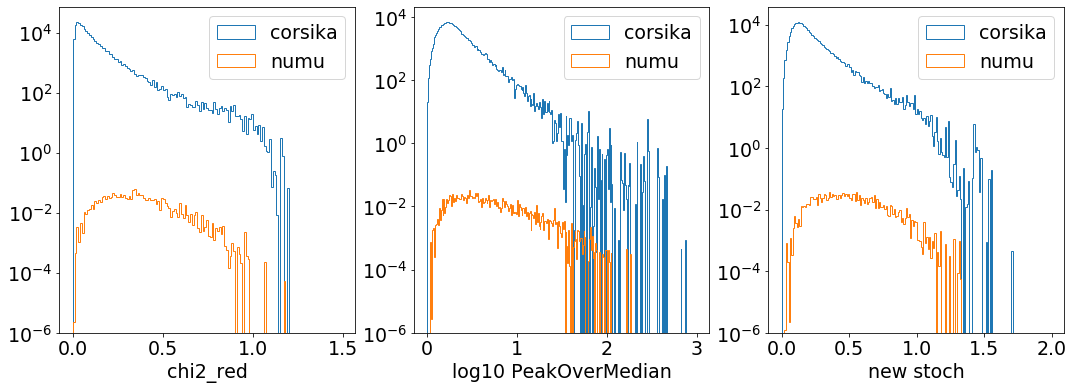

In [77]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.hist(chi2_red_corsika,bins=np.arange(0,1.5,0.01),weights=weight_corsika,histtype='step',log=True,label='corsika',bottom=10**(-6))
plt.hist(chi2_red_numu,bins=np.arange(0,1.5,0.01),weights=weight_numu_astro,histtype='step',log=True,label='numu',bottom=10**(-6))
# plt.axvline(chi2_red_cut,label=r'$\chi^2_{red}=$'+str(chi2_red_cut),color='b')
plt.legend()
plt.xlabel('chi2_red')

plt.subplot(132)
plt.hist(np.log10(PeakOverMedian_corsika),bins=np.arange(0,3.0,0.01),weights=weight_corsika,histtype='step',log=True,label='corsika',bottom=10**(-6))
plt.hist(np.log10(PeakOverMedian_numu),bins=np.arange(0,3.0,0.01),weights=weight_numu_astro,histtype='step',log=True,label='numu',bottom=10**(-6))
# plt.axvline(pom_cut,label=r'$logPeakOverMedian=$'+str(pom_cut),color='g')
plt.legend(loc='upper right')
plt.xlabel('log10 PeakOverMedian')

plt.subplot(133)
plt.hist(stoch_corsika,bins=np.arange(0,2.0,0.01),weights=weight_corsika,histtype='step',log=True,label='corsika',bottom=10**(-6))
plt.hist(stoch_numu,bins=np.arange(0,2.0,0.01),weights=weight_numu_astro,histtype='step',log=True,label='numu',bottom=10**(-6))
# plt.axvline(pom_cut,label=r'$logPeakOverMedian=$'+str(pom_cut),color='g')
plt.legend(loc='upper right')
plt.xlabel('new stoch')

plt.savefig(fig_dir + 'hist1d_stochasticity.png',dpi=300,bbox_inches='tight')
plt.show()